In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

In [3]:
plt.style.use('ggplot')

In [4]:
senti_df = pd.read_csv('sentiment_data.csv')
senti_df = senti_df[(senti_df['symbol'] != 'MRO')&(senti_df['symbol'] != 'ATVI')]
senti_df['date'] = pd.to_datetime(senti_df['date'])
senti_df = senti_df.set_index(['date', 'symbol'])
senti_df['engagement_ratio'] = senti_df['twitterComments'] / senti_df['twitterLikes']
senti_df = senti_df[(senti_df['twitterLikes']>20)&(senti_df['twitterComments']>10)]
senti_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           BA              61.0             55.0         342.0   
           CRM             25.0           7183.0       29832.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           BA                425847.0               NaN          0.160819  
           CRM               142826.0               NaN          0.240782  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[24709 rows x 6 columns]

In [5]:
aggr_df = senti_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol'])[['engagement_ratio']].mean()
aggr_df['rank'] = aggr_df.groupby(level=0)['engagement_ratio'].transform(lambda x: x.rank(ascending=False))
aggr_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  70.0
           TSN             0.280553  29.0
           V               0.194045  58.0
           XOM             0.217904  51.0

[1081 rows x 2 columns]

In [6]:
filtered_df = aggr_df[aggr_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])
filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

In [7]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['D', 'FCX', 'GILD', 'LUV', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [8]:
stocks_list = senti_df.index.get_level_values('symbol').unique().tolist()
prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

prices_df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  83 of 83 completed


Price            Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.582748  15.13  143.031021  126.405235   88.933960  101.045952   
2021-01-05  116.527771  15.43  142.876495  127.968063   89.853584  102.296188   
2021-01-06  119.723244  15.52  151.130753  123.660492   89.077370  102.083206   
2021-01-07  122.908981  15.38  152.421616  127.880165   90.030754  103.074112   
2021-01-08  123.785774  15.13  154.594254  128.983932   90.503227  103.361198   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.083115  15.56  137.374588  147.423279  139.722900   98.635506   
2023-02-23  141.187378  15.87  135.834610  147.908386  141.021164   98.501038   
2023-02-24  139.215485  15.56  132.812042  145.245239  141.614685   96.493553   
2023-02-27  140.181702  15.63  134.514618  146.443161  143.070572   95.830788   
2023-02-28  139.974670  15.98  138.656342  145.938278  142.718201   97.703804   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  69.613190  20.197660  146.840118  92.300003  ...  5732800   
2021-01-05  69.519279  20.875547  156.749405  92.769997  ...  4029500   
2021-01-06  70.074211  21.709873  168.457748  90.330002  ...  3612500   
2021-01-07  68.204536  21.492603  177.020142  95.160004  ...  3993700   
2021-01-08  67.598381  22.092276  177.116348  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  83.843124  23.392221  240.589996  76.610001  ...  2044600   
2023-02-23  83.741577  23.392221  247.814056  79.750000  ...  2066600   
2023-02-24  83.483078  23.327726  243.587036  78.089996  ...  2875100   
2023-02-27  83.150726  22.922352  250.908661  78.769997  ...  2459700   
2023-02-28  81.212067  22.738087  248.263107  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 415 columns]

In [9]:
returns_df = np.log(prices_df['Close']).diff()
returns_df = returns_df.iloc[1:,:]

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    temp_df = returns_df[cols][start_date:end_date].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)


portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


In [10]:
qqq_df = yf.download(tickers='QQQ', start='2021-01-01', end='2023-03-01')
qqq_returns = np.log(qqq_df['Close']).diff()
portfolio_df = portfolio_df.merge(qqq_returns, left_index=True, right_index=True)
portfolio_df

[*********************100%***********************]  1 of 1 completed


,portfolio_return,QQQ
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


In [20]:
sum = np.exp(np.sum(np.log1p(portfolio_df))) - 1
sum

c:\Users\mv639\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


portfolio_return    0.000832
QQQ                -0.290883
dtype: float64

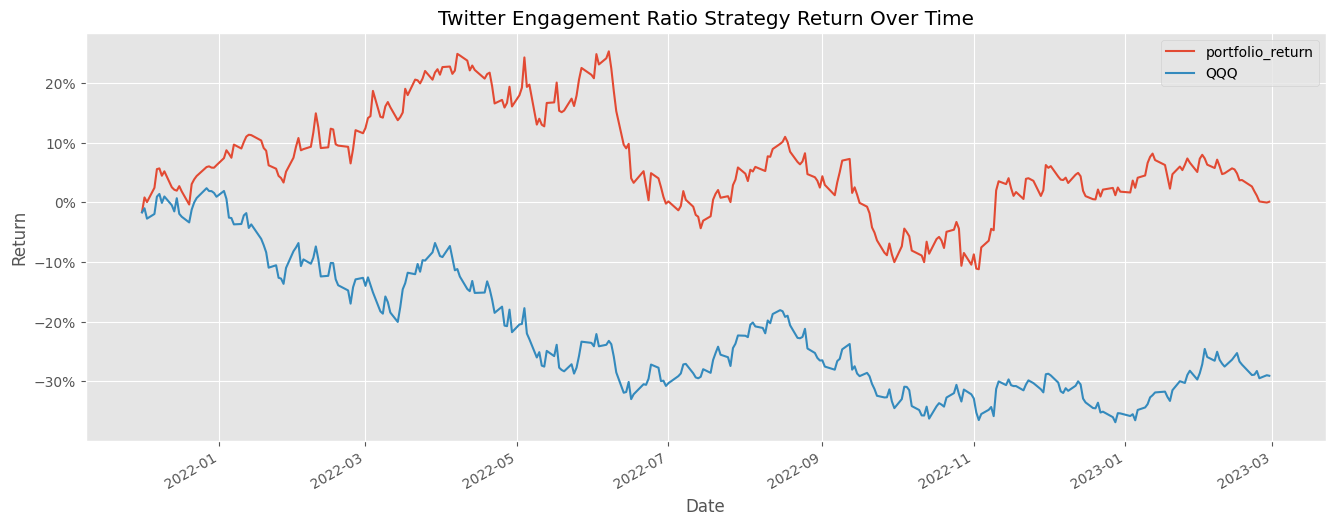

In [11]:
import matplotlib.ticker  as mtick


portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [17]:
portfolios_cumulative_return['QQQ']

Date
2021-12-01   -0.017159
2021-12-02   -0.010101
2021-12-03   -0.027466
2021-12-06   -0.019704
2021-12-07    0.009381
                ...   
2023-02-22   -0.289068
2023-02-23   -0.282886
2023-02-24   -0.294995
2023-02-27   -0.289964
2023-02-28   -0.290883
Name: QQQ, Length: 312, dtype: float64